# Score
local:
kaggle:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import lightgbm
import warnings
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings("ignore")


# Load Data

In [3]:
# 캐글 실행용
# df_train = pd.read_csv('../input/playground-series-s3e23/train.csv', index_col='id')
# df_test = pd.read_csv('../input/playground-series-s3e23/test.csv', index_col='id')
# df_original = pd.read_csv('/kaggle/input/software-defect-prediction/jm1.csv')

# 로컬
df_train = pd.read_csv("./playground-series-s3e23/train.csv", index_col="id")
df_test = pd.read_csv("./playground-series-s3e23/test.csv", index_col="id")
df_original = pd.read_csv("./software-defect-prediction/jm1.csv")


# Feature

## Original 과  train 을 합치는 코드 

In [4]:
# columns = ["uniq_Op", "uniq_Opnd", "total_Op", "total_Opnd", "branchCount"]
# 
# for col in columns:
#     df_original[col][df_original[col] == "?"] = np.nan
#     df_original[col] = df_original[col].astype(float)
# 
# 
# df_train = pd.concat([df_train, df_original], ignore_index=True)
# df_train = df_train.drop_duplicates()
# df_train['defects'] = df_train.defects.astype(int)


## Quantile Transformer 
+ 여기서 train['defects']에 nan이 생김 -> 위치 바꿔줌
+ scale 해주는 함수

In [5]:
# feat_list = list(set(df_train.columns) - set(['defects']))
# target = 'defects'

In [4]:
# qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=0)
# qt.fit(df_train[feat_list])
# 
# tmp_train = pd.DataFrame(qt.transform(df_train[feat_list]))
# tmp_train.columns = feat_list
# tmp_train[target] = df_train[target]
# df_train = tmp_train
# df_test = pd.DataFrame(qt.transform(df_test[feat_list]))
# df_test.columns = feat_list
# 
# feat_list = list(set(df_train.columns.tolist()) - set([target]))


In [5]:
# device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")


## drop N/A

In [8]:
# df_train.dropna(axis=0,inplace=True)
# df_train

,branchCount,lOComment,l,v,v(g),locCodeAndComment,uniq_Opnd,e,ev(g),uniq_Op,...,t,lOCode,loc,n,i,b,iv(g),total_Op,total_Opnd,defects
0,0.447447,0.747247,0.369870,0.561052,0.440941,0.000000,0.372873,0.643644,0.0,0.755756,...,0.639643,0.592593,0.477978,0.563564,0.208466,0.549550,0.412913,0.577077,0.519019,False
1,0.259760,0.000000,0.737237,0.361361,0.256256,0.000000,0.465465,0.327711,0.0,0.463964,...,0.327972,0.420921,0.279780,0.331832,0.436436,0.355856,0.412913,0.309810,0.354354,False
2,0.259760,0.000000,0.620621,0.448949,0.256256,0.000000,0.465465,0.450299,0.0,0.540040,...,0.447915,0.301301,0.191692,0.457958,0.483483,0.464965,0.412913,0.465465,0.426426,False
3,0.000000,0.000000,0.847347,0.243744,0.000000,0.000000,0.213714,0.222803,0.0,0.259259,...,0.223223,0.149149,0.102603,0.229730,0.331665,0.231231,0.000000,0.274775,0.171171,True
4,0.259760,0.000000,0.830330,0.158158,0.256256,0.000000,0.213714,0.198198,0.0,0.201702,...,0.198699,0.261762,0.191692,0.159159,0.150150,0.156156,0.412913,0.161161,0.258258,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110669,0.259760,0.000000,0.481481,0.694059,0.256256,0.000000,0.753253,0.652503,0.0,0.463964,...,0.648203,0.615115,0.524024,0.706206,0.804073,0.703203,0.412913,0.666166,0.736737,False
110671,0.259760,0.000000,0.664164,0.316316,0.256256,0.000000,0.324825,0.352316,0.0,0.540040,...,0.352699,0.183684,0.131131,0.313814,0.258150,0.297798,0.412913,0.326326,0.282783,False
110672,0.573574,0.747247,0.221221,0.718622,0.568569,0.000000,0.624124,0.795790,0.0,0.834334,...,0.792231,0.777277,0.740741,0.734234,0.390390,0.720721,0.412913,0.708709,0.736737,False
110673,0.000000,0.000000,0.664164,0.352352,0.000000,0.000000,0.324825,0.377547,0.0,0.323824,...,0.378893,0.221722,0.160661,0.374374,0.316459,0.355856,0.000000,0.359860,0.379379,False


## iqr outlier detection

In [9]:
# def iqr_outlier_detection(data):
# 
#     q1, q3 = np.percentile(data, [25, 75])
#  
#     iqr = q3 - q1
# 
#     threshold = iqr * 1.5
#     outliers = [x for x in data if x < q1 - threshold or x > q3 + threshold]
# 
#     data_filtered = data[~np.isin(data, outliers)]
# 
#     return data_filtered


In [10]:
# for col in df_train.columns:
#   iqr_outlier_detection(df_train[col])


## Feature Engineering Tryout by jinsoolve

In [12]:
df_test['l']  = 1.0 - df_test['l']
df_train['l'] = 1.0 - df_train['l']


In [13]:
# def add_feat(X):
#     df = X.copy()
#     df["mean_bnv"] = (df["n"] + df["v"] + df["b"]) / 3
#     df["mean_uniqOpOpend"] = (df["uniq_Op"] + df["uniq_Opnd"]) / 2
#     df["mean_totOpOpend"] = (df["total_Op"] + df["total_Opnd"]) / 2
#     df["mean_brcntvg"] = (df["branchCount"] + df["v(g)"]) / 2
#     return df
# 
# 
# df_train = add_feat(df_train)
# df_test = add_feat(df_test)
# 
# ### HERE ###############
# df_train.dropna(axis=0,inplace=True)
# ### HERE ###############


### Log
로그 변홤과 정규화를 시키고 PCA(주성분 분석)을 하여 데이터 차원을 축소시킨다.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

colnames = df_train.drop(columns = ['defects'], axis = 1).columns.tolist()

pca_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA())]).fit(df_train[colnames])

pca_md

Pipeline(steps=[('log-tran',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['loc', 'v(g)', 'ev(g)',
                                                   'iv(g)', 'n', 'v', 'l', 'd',
                                                   'i', 'e', 'b', 't', 'lOCode',
                                                   'lOComment', 'lOBlank',
                                                   'locCodeAndComment',
                                                   'uniq_Op', 'uniq_Opnd',
                                                   'total_Op', 'total_Opnd',
                                                   'branchCount'])])),
                ('stand', StandardScaler()), ('pca', PCA())])

### K-means Clustering
"클러스터"는 데이터 마이닝 및 기계 학습에서 사용되는 용어로, 유사한 데이터 포인트의 그룹을 나타냅니다.  
클러스터링은 비슷한 데이터를 그룹화하여 패턴을 발견하거나 데이터를 간소화하는 비지도 학습 방법 중 하나입니다.

100%|██████████| 19/19 [00:28<00:00,  1.49s/it]


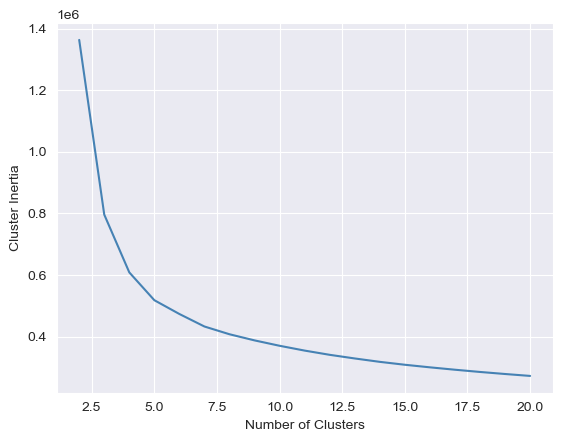

In [10]:
from sklearn.cluster import KMeans

inertias = list()

for i in tqdm(range(2, 21)):

    kmeans_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                          ('stand', StandardScaler()), 
                          ('kmeans', KMeans(n_clusters = i, n_init = 20, random_state = 42))]).fit(df_train[colnames])

    inertias.append(kmeans_md['kmeans'].inertia_)
    
sns.lineplot(x = [i for i in range(2, 21)], y = inertias, color = 'steelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia');

In [15]:
kmeans = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('kmeans', KMeans(n_clusters = 5, n_init = 20, random_state = 42))]).fit(df_train[colnames])

df_train['cluster'] = kmeans['kmeans'].labels_

print('The proportion of defects in each of the clusters is \n')
print(df_train.groupby('cluster')['defects'].mean())

The proportion of defects in each of the clusters is 

cluster
0    0.109429
1    0.471916
2    0.641147
3    0.077083
4    0.301682
Name: defects, dtype: float64


In [16]:
df_train.nunique()

loc                   378
v(g)                  106
ev(g)                  71
iv(g)                  84
n                     836
v                    4515
l                      55
d                    3360
i                    5171
e                    8729
b                     315
t                    8608
lOCode                298
lOComment              91
lOBlank                94
locCodeAndComment      29
uniq_Op                70
uniq_Opnd             176
total_Op              623
total_Opnd            485
branchCount           144
defects                 2
cluster                 5
dtype: int64

# Modeling

In [17]:
X_train = df_train.drop(['defects', 'cluster'], axis=1)
y_train = df_train['defects']
X_test = df_test

X_train


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,811.70,...,45.09,7,0,1,0,11.0,8.0,16.0,12.0,3.0
101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,11268.27,...,626.01,23,0,2,0,18.0,20.0,67.0,40.0,9.0
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,327.43,20,0,4,0,10.0,8.0,51.0,28.0,1.0


In [18]:
X_train = X_train.apply(lambda x: np.log1p(x))
X_test = X_test.apply(lambda x: np.log1p(x))

## Evaluation Metric (AUC)

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

def roc_auc(true_list, pred_list, figlen):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)
    print(f'\nROC_AUC: %0.6f\n' %roc_auc)
    
    if (figlen > 0):
        sns.set()
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(figlen, figlen), facecolor='lightyellow')
        plt.gca().set_facecolor('lightgray')
        plt.fill_between(fpr, tpr, color='r', alpha=0.1)
        plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('The area under the ROC curve\n', fontsize=16, c='darkred')
        plt.legend(loc="lower right")
        plt.show()

## HyperParameter Tuning

In [20]:
from bayes_opt import BayesianOptimization


def lgbm_cl_bo(min_child_samples, colsample_bytree, learning_rate, num_leaves, reg_alpha, reg_lambda):
    
    params_lgbm = {}
    params_lgbm['min_child_samples'] = round(min_child_samples)
    params_lgbm['colsample_bytree'] = colsample_bytree
    params_lgbm['learning_rate'] = learning_rate
    params_lgbm['num_leaves'] = round(num_leaves)
    params_lgbm['reg_alpha'] = reg_alpha
    params_lgbm['reg_lambda'] = reg_lambda    
       
    params_lgbm['boosting_type'] ='gbdt'   # Manual optimization
    params_lgbm['objective'] ='binary'     # Manual optimization
    params_lgbm['subsample'] = 1.0
    params_lgbm['max_bin'] = 1023
    params_lgbm['n_jobs'] = -1
    params_lgbm['verbose'] = -1

    scores = cross_val_score(LGBMClassifier(**params_lgbm, random_state=2920), X_train, y_train, scoring='roc_auc', cv=5).mean()
    score = scores.mean()
    return score

In [21]:
params_lgbm ={'min_child_samples':(800, 1200),
              'colsample_bytree':(0.3, 1.0),
              'learning_rate':(0.005, 0.1),
              'num_leaves':(20, 60),
              'reg_alpha':(0.0, 10.0),
              'reg_lambda':(0.0, 5.0)}

# lgbm_bo = BayesianOptimization(lgbm_cl_bo, params_lgbm, random_state=2920)
# import warnings
# warnings.filterwarnings('ignore')
# lgbm_bo.maximize(n_iter=30, init_points=20)

## Hill Climbing Ensemble

In [22]:
def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.71, 0.01)
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0
    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]


## hyperparameter sets

In [23]:
random_state = 43

lgb_params0 = {
    "objective": 'binary',
    'metric': 'auc',
    'boosting_type': 'dart',
     "n_estimators": 1000,
     "max_depth": 7,
     "learning_rate":0.03,
     "num_leaves": 50,
     "reg_alpha":3,
     "reg_lambda": 3,
     "subsample": 0.7,
     'device': 'gpu' if torch.cuda.is_available() else 'cpu',
     "colsample_bytree": 0.7,
     'verbose': -1,
}

lgb_params1 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'dart',
    'random_state': 42,
    'colsample_bytree': 0.50,
    'subsample': 0.70,
    'learning_rate': 0.0625,
    'max_depth': -1,
    'n_estimators': 100,
    'num_leaves': 20,
    'reg_alpha': 0.0001,
    'reg_lambda': 2.0,
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    'random_state': random_state,
    'verbose': -1,  
}

lgb_params2 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'colsample_bytree': 0.50,
    'subsample': 0.70,
    'learning_rate': 0.0625,
    'max_depth': -1,
    'n_estimators': 100,
    'num_leaves': 20,
    'reg_alpha': 0.0001,
    'reg_lambda': 2.0,
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    'random_state': random_state,
    'verbose': -1,
}
lgb_params3 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': 42,
    
    'colsample_bytree': 0.5688,
    'learning_rate': 0.07712,
    'min_child_samples': 864,
    'num_leaves': 23,
    'reg_alpha': 0.6515,
    'reg_lambda': 3.118,
    
    'subsample': 0.70, 
    'max_depth': -1,
    'n_estimators': 100,
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    'random_state': random_state,
    'verbose': -1,
}

xgb_optuna0 = {
    'n_estimators': 10000,
    'learning_rate': 0.01752354328845971,
    'booster': 'gbtree',
    'lambda': 0.08159630121074074,
    'alpha': 0.07564858712175693,
    'subsample': 0.5065979400270813,
    'colsample_bytree': 0.6187340851873067,
    'max_depth': 4,
    'min_child_weight': 5,
    'eta': 0.2603059902806757,
    'gamma': 0.6567360773618207,
    'early_stopping_rounds': 100,
    'tree_method': 'hist',
    'random_state': random_state
}

xgb_params0 = {
    'n_estimators': 10000,
    'learning_rate': 0.09641232707445854,
    'booster': 'gbtree',
    'lambda': 4.666002223704784,
    'alpha': 3.708175990751336,
    'subsample': 0.6100174145229473,
    'colsample_bytree': 0.5506821152321051,
    'max_depth': 7,
    'min_child_weight': 3,
    'eta': 1.740374368661041,
    'gamma': 0.007427363662926455,
    'grow_policy': 'depthwise',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'verbosity': 0,
    'random_state': random_state,
    'early_stopping_rounds': 100,
    'tree_method': 'hist',
}

xgb_params1 = {
    'n_estimators': 10000,
    'learning_rate': 0.012208383405206188,
    'booster': 'gbtree',
    'lambda': 0.009968756668882757,
    'alpha': 0.02666266827121168,
    'subsample': 0.7097814108897231,
    'colsample_bytree': 0.7946945784285216,
    'max_depth': 3,
    'min_child_weight': 4,
    'eta': 0.5480204506554545,
    'gamma': 0.8788654128774149,
    'scale_pos_weight': 4.71,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 100,
    'verbosity': 0,
    'random_state': random_state,
    'tree_method': 'hist',
}



xgb_params2 = {
    'n_estimators': 10000,
    'colsample_bytree': 0.5646751146007976,
    'gamma': 7.788727238356553e-06,
    'learning_rate': 0.1419865761603358,
    'max_bin': 824,
    'min_child_weight': 1,
    'random_state': 811996,
    'reg_alpha': 1.6259583347890365e-07,
    'reg_lambda': 2.110691851528507e-08,
    'subsample': 0.879020578464637,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'early_stopping_rounds': 100,
    'n_jobs': -1,
    'verbosity': 0,
    'random_state': random_state,
    'tree_method': 'hist',
   # 'scale_pos_weight': scale_pos_weight
}

xgb_params3 = {
    'n_estimators': 10000,
    'random_state': random_state,
    'colsample_bytree': 0.4836462317215041,
    'eta': 0.05976752607337169,
    'gamma': 1,
    'lambda': 0.2976432557733288,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 550,
    'early_stopping_rounds': 100,
    'objective': 'binary:logistic',
    'scale_pos_weight': 4.260162886376033,
    'subsample': 0.7119282378433924,
    'tree_method': 'hist',
}

xgb_params4 = {
    'n_estimators': 10000,
    'colsample_bytree': 0.8757972257439255,
    'gamma': 0.11135738771999848,
    'max_depth': 7,
    'min_child_weight': 3,
    'reg_alpha': 0.4833998914998038,
    'reg_lambda': 0.006223568555619563,
    'scale_pos_weight': 8,
    'subsample': 0.7056434340275685,
    'random_state': random_state,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
}

xgb_params5 = {
    'n_estimators': 10000,
    'max_depth': 5,
    'min_child_weight': 2.934487833919741,
    'learning_rate': 0.11341944575807082,
    'subsample': 0.9045063514419968,
    'gamma': 0.4329153382843715,
    'colsample_bytree': 0.38872702868412506,
    'colsample_bylevel': 0.8321880031718571,
    'colsample_bynode': 0.802355707802605,
    'random_state': random_state,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
}

xgb_base = {
    'n_estimators': 1000,
    'verbosity': 0,
    'random_state': random_state,
}

xgb_params6 = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.7,
    'gamma': 2,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 10,
    'n_estimators': 10000,
    'subsample':0.7,
    'random_state': random_state,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
}

cat_params0 = {
    'iterations': 10000,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'early_stopping_rounds': 100,
    'auto_class_weights': 'Balanced'
}


## class initialization

In [24]:
from abc import ABCMeta
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

class BaseModel(metaclass=ABCMeta):
    def __init__(self):
        pass

    def train(self, trn_x, trn_y, val_x, val_y):
        pass

    def predict(self, X):
        pass


class RandomForestModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = None

    def train(self, trn_x, trn_y, val_x, val_y):
        self.model = RandomForestClassifier(n_estimators = 1000,
                                            class_weight='balanced',
                                           max_depth = 7,
                                           min_samples_split = 15,
                                           min_samples_leaf = 10)
        self.model.fit(trn_x, trn_y)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

class HistGradientBoostingModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = None

    def train(self, trn_x, trn_y, val_x, val_y):
        self.model = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = True,
                                             learning_rate = 0.01,
                                             max_iter = 1000,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10)
        self.model.fit(trn_x, trn_y)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

class LGBMModel(BaseModel):
    def __init__(self, **config):
        super().__init__()
        self.config = config
        self.model = LGBMClassifier(**self.config)

    def train(self, trn_x, trn_y, val_x, val_y):
        self.model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)])

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]


class XGBModel(BaseModel):
    def __init__(self, **config):
        super().__init__()
        self.config = config
        self.model = XGBClassifier(**self.config)

    def train(self, trn_x, trn_y, val_x, val_y):
        self.model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=0)


    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

class CatBoostModel(BaseModel):
    def __init__(self, **config):
        super().__init__()
        self.config = config
        self.model = CatBoostClassifier(**self.config)

    def train(self, trn_x, trn_y, val_x, val_y):
        self.model.fit(trn_x, trn_y, eval_set=(val_x, val_y), verbose=0)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]


In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold

def train(X_train, y_train, X_test, models, n_folds=10):

    valid_preds, test_preds = dict(), dict()
    hill_ens_preds =  list()

    sk = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = 1, random_state = 42)
    for i, (trn_idx, val_idx) in enumerate(sk.split(X_train, y_train)):

        trn_x, trn_y = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
        val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

        print('----------------------------------------------------------')
        ens_pred_1 = np.zeros((val_x.shape[0], ))
        ens_pred_2 = np.zeros((X_test.shape[0], ))

        for idx, model in enumerate(models):
            print("model", model)
            model.train(trn_x, trn_y, val_x, val_y)

            ens_pred_1 = model.predict(val_x)
            ens_pred_2 = model.predict(X_test)
            
            print(f"ROC: {roc_auc_score(val_y, ens_pred_1)}")
            
            valid_preds[f'model_{idx}'] = ens_pred_1
            test_preds[f'model_{idx}'] = ens_pred_2

        ens_pred_1 = np.mean(list(valid_preds.values()), axis=0)
        ens_pred_2 = np.mean(list(test_preds.values()), axis=0)


        ens_score_fold = roc_auc_score(val_y, ens_pred_1)
        print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)

        ############################
        ## Hill Climbing Ensemble ##
        ############################

        x = pd.DataFrame(valid_preds)
        y = val_y
        x_test = pd.DataFrame(test_preds)

        hill_results = hill_climbing(x, y, x_test)
        hill_ens_score_fold = roc_auc_score(y, hill_results[0])

        # test preds
        hill_ens_preds.append(hill_results[1])

        print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)
        
    return hill_ens_preds

In [26]:
# X_train, X_test, y_train = df_train[feat_list], df_test[feat_list], df_train[target]


In [27]:
models_v1 = [XGBModel(**xgb_optuna0), 
             XGBModel(**xgb_params3),
             XGBModel(**xgb_params6),
             LGBMModel(**lgb_params0), 
             LGBMModel(**lgb_params1),
             LGBMModel(**lgb_params2),
             HistGradientBoostingModel(), 
             CatBoostModel(**cat_params0)]

In [28]:
hill_ens_preds = train(X_train, y_train, X_test, models_v1, n_folds=10)


----------------------------------------------------------
model <__main__.XGBModel object at 0x2b25a77f0>
ROC: 0.791905333141662
model <__main__.XGBModel object at 0x2b25a7040>
ROC: 0.7856301935053197
model <__main__.XGBModel object at 0x2b25a75e0>
ROC: 0.7920458920395306
model <__main__.LGBMModel object at 0x2b25d3490>
ROC: 0.7909397067320111
model <__main__.LGBMModel object at 0x2b25d35e0>
ROC: 0.7886187499621339
model <__main__.LGBMModel object at 0x2b25d3250>
ROC: 0.7914641588579919
model <__main__.HistGradientBoostingModel object at 0x2b25d3430>
ROC: 0.7893555550782134
model <__main__.CatBoostModel object at 0x2b25d37f0>
ROC: 0.7909263503320374
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.7918598112258751
Fold 0 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7927499808604167
----------------------------------------------------------
model <__main__.XGBModel object at 0x2b25a77f0>
ROC: 0.8014839373455409
model <__main__.XGBModel object at 0x2b25a7040>
ROC: 0.79106

In [29]:
# hill climbing
# 캐글 제출용
# submission = pd.read_csv('/kaggle/input/playground-series-s3e23/sample_submission.csv')

# 로컬
submission = pd.read_csv('./playground-series-s3e23/sample_submission.csv')

submission['defects'] = np.mean(hill_ens_preds, axis=0)
submission.to_csv('submission.csv', index=False)


In [30]:
submission

,id,defects
0,101763,0.256096
1,101764,0.213431
2,101765,0.686997
3,101766,0.501015
4,101767,0.161758
...,...,...
67837,169600,0.298546
67838,169601,0.135904
67839,169602,0.195785
67840,169603,0.112368
